In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf 
print(tf.__version__)

2.4.0


In [ ]:
# !python3 -m pip uninstall tensorflow
# !python3 -m pip install tensorflow==2.2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
%cd gdrive/MyDrive/project
!ls

/content/gdrive/MyDrive/project
Backup		Demo.ipynb  NewDataHammad  tools
custom_dataset	IMAGES	    __pycache__    train.py
custom_model	model_data  tflite_models  yolov3


In [ ]:
import tensorflow as tf 
print(tf.__version__)

2.4.0


In [ ]:
# from train import *
# tf.keras.backend.clear_session()
# main()

In [ ]:
import cv2
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import glob
from google.colab.patches import cv2_imshow
from yolov3.utils import load_yolo_weights, detect_image
from yolov3.configs import *
from yolov3.yolov3 import *
from yolov3.yolov3 import decode, YOLOv3_tiny

In [ ]:
def Create_Yolov3_Mobile(input_size=416, channels=3, training=False, CLASSES=YOLO_COCO_CLASSES):
    NUM_CLASS = len(read_class_names(CLASSES))
    input_layer  = Input([input_size, input_size, channels])

    if TRAIN_YOLO_TINY:
        print("Tiny Model Created")
        conv_tensors = YOLOv3_tiny(input_layer, NUM_CLASS)
    else:
        print("Normal Model Created")
        conv_tensors = YOLOv3(input_layer, NUM_CLASS)

    output_tensors = []
    for i, conv_tensor in enumerate(conv_tensors):
        pred_tensor = decode(conv_tensor, NUM_CLASS, i)
        if training: output_tensors.append(conv_tensor)
        output_tensors.append(pred_tensor)
    output_tensors = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in output_tensors]
    output_tensors = tf.concat(output_tensors, axis=0)
    YoloV3 = tf.keras.Model(input_layer, output_tensors)
    
    return YoloV3


In [ ]:
new_yolo = Create_Yolov3_Mobile(input_size= 416, CLASSES= "model_data/projector_names.txt",)
new_yolo.load_weights("custom_model/yolov3_projector_custom_Tiny") # use keras weight
input_shape = new_yolo.inputs[0].shape.as_list()
output_shape = new_yolo.outputs[0].shape.as_list()
input_shape[0] = 1

print(input_shape,output_shape)
tf.keras.Model.save(new_yolo, "tflite_models/projector_lite_model")
func = tf.function(new_yolo).get_concrete_function(
    tf.TensorSpec(input_shape, new_yolo.inputs[0].dtype))

Tiny Model Created
[1, 416, 416, 3] [None, None]
INFO:tensorflow:Assets written to: tflite_models/projector_lite_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("tflite_models/projector_lite_model/",signature_keys=['serving_default'])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

lite_model = converter.convert()

open("tflite_models/projector_lite_model-concrete.tflite",'wb').write(lite_model)
size = os.path.getsize("tflite_models/projector_lite_model-concrete.tflite")
print(round(size/(1024*1024),3),"MB")

33.096 MB


In [ ]:
# new_yolo = Create_Yolov3(input_size= 416, CLASSES= "model_data/projector_names.txt",)
# new_yolo.load_weights("custom_model/yolov3_projector_custom_Tiny") # use keras weights

In [ ]:
from yolov3.utils import postprocess_boxes,nms,draw_bbox
def image_preprocess(image, target_size):
    ih, iw    = target_size
    h,  w, _  = image.shape
    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    print(nw,nh)
    image_resized = cv2.resize(image, (nw,nh), interpolation = cv2.INTER_AREA)
    # image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.
    return image_paded
    #return resized   
def preprocess_image(image_path,input_size):
    original_image = cv2.imread(image_path)
    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    return original_image,image_data

def detect_image(original_image, pred_bbox, input_size=416,CLASSES=TRAIN_CLASSES, score_threshold=0.4, iou_threshold=0.3, rectangle_colors=''):
    
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
    bboxes = nms(bboxes= bboxes,iou_threshold=iou_threshold)
    image = draw_bbox(original_image, bboxes, CLASSES=CLASSES, rectangle_colors=rectangle_colors)
    
    return image

custom_dataset/test/projector/frame2700.jpg
416 416
(1, 416, 416, 3)
(2535, 6)
2320 0.9124148
[203.96902465820312, 245.8399658203125, 129.1471710205078, 123.7846450805664, 0.9135526418685913, 0.9996434450149536]
[[139.39543914794922, 183.9476432800293, 268.54261016845703, 307.7322883605957, 0.9135526418685913, 0.9996434450149536]]


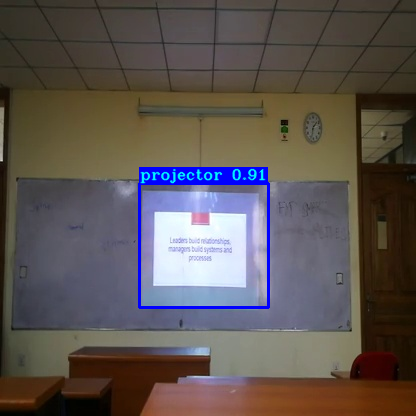

In [ ]:
image_path = "custom_dataset/test/projector/frame2700.jpg"
print(image_path)
original_image,input_data = preprocess_image(image_path,416)
interpreter = tf.lite.Interpreter(model_path="tflite_models/projector_lite_model-concrete-2.tflite")
interpreter.allocate_tensors()
print(input_data.shape)
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_tensors = interpreter.get_tensor(output_details[0]['index'])
print(output_tensors.shape)
maxScore = 0 
index = 0
for i in range(output_tensors.shape[0]):
  score = output_tensors[i][4] * output_tensors[i][5]
  if(score > 0.4 and score > maxScore):
    maxScore = score
    index = i
print(index,maxScore)
cors = output_tensors[index]
cors = [203.96902465820312, 245.8399658203125, 129.1471710205078, 123.7846450805664, 0.9135526418685913, 0.9996434450149536]
print(cors)
input_size = 416
org_h, org_w = original_image.shape[:2]

#print("My points: ", cors)
resize_ratio = min(input_size / org_w, input_size / org_h)

xmin = cors[0] - cors[2] * 0.5
ymin = cors[1] - cors[3] * 0.5
xmax = cors[0] + cors[2] * 0.5
ymax = cors[1] + cors[3] * 0.5


dw = (input_size - resize_ratio * org_w) / 2
dh = (input_size - resize_ratio * org_h) / 2

xmin = int(abs(1.0 * (xmin - dw) / resize_ratio))
xmax = int(abs(1.0 * (xmax - dw) / resize_ratio))
ymin = int(abs(1.0 * (ymin - dh) / resize_ratio))
ymax = int(abs(1.0 * (ymax - dh) / resize_ratio))
xmin = 139.39543914794922 
xmax= 268.54261016845703 
ymin = 183.9476432800293 
ymax = 307.7322883605957

points = [[xmin,ymin,xmax,ymax,cors[4],cors[5]]]
print(points)
#pred = detect_image(original_image,output_tensors ,CLASSES= "model_data/projector_names.txt")
pred = draw_bbox(original_image, points, CLASSES="model_data/projector_names.txt")
cv2_imshow(pred)

In [ ]:
['IMAGES/3.jpg', 'IMAGES/6.jpg', 'IMAGES/8.jpg', 'IMAGES/7.jpg', 'IMAGES/g (36).jpg', 'IMAGES/10.jpg']
(1, 416, 416, 3)
(2535, 6)
2293 0.6427754
[326.16785    204.83789    125.69845    139.21738      0.64725703
   0.99307597]
[[2511, 793, 3710, 793, 0.64725703, 0.99307597]]

In [ ]:
output_tensors[2320]


array([203.91522   , 245.8222    , 129.04327   , 123.79155   ,
         0.91274536,   0.99963784], dtype=float32)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="tflite_models/whiteboard_lite_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

pred_bbox = []
pred_bbox.append(interpreter.get_tensor(output_details[0]['index']))
pred_bbox.append(interpreter.get_tensor(output_details[1]['index']))

pred = detect_image(original_image,pred_bbox,CLASSES= "model_data/whiteboard_names.txt")
cv2_imshow(pred)

ValueError: ignored

In [ ]:
interpreter = tf.lite.Interpreter(model_path="tflite_models/person_lite_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

pred_bbox = []
#pred_bbox.append(interpreter.get_tensor(output_details[0]['index']))
pred_bbox.append(interpreter.get_tensor(output_details[1]['index']))
pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
print(pred_box.shape)

#pred = detect_image(original_image,pred_bbox,CLASSES= YOLO_COCO_CLASSES)
cv2_imshow(pred)

ValueError: ignored

In [ ]:
images = glob.glob("./IMAGES/test/*.jpg") 

for image in images:
    cv2.imwrite("./IMAGES/results/"+ image[image.rfind('/') + 1 :], img)